In [1]:
! gdown 1GhhEqa4HtpB8zvvX6JNPPxndpaF4hE2s
! unzip -q PRSA2017_Data

Downloading...
From: https://drive.google.com/uc?id=1GhhEqa4HtpB8zvvX6JNPPxndpaF4hE2s
To: /content/PRSA2017_Data.zip
100% 9.03M/9.03M [00:00<00:00, 17.0MB/s]


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import seaborn as sns

In [48]:
! pip install -q tensorflow_addons
from tensorflow_addons.metrics import RSquare

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, TimeDistributed, MaxPooling1D, Flatten, LSTM, BatchNormalization

In [3]:
csv_paths = os.listdir('/content/PRSA2017_Data_20130301-20170228/PRSA_Data_20130301-20170228')
csv_paths = ['/content/PRSA2017_Data_20130301-20170228/PRSA_Data_20130301-20170228/'+path for path in csv_paths]

In [4]:
sites = [csv_paths[i][79:-22] for i in range(len(csv_paths))]
sites

['Gucheng',
 'Tiantan',
 'Dongsi',
 'Guanyuan',
 'Nongzhanguan',
 'Wanliu',
 'Dingling',
 'Shunyi',
 'Changping',
 'Aotizhongxin',
 'Huairou',
 'Wanshouxigong']

In [5]:
dfs = {}
for path in csv_paths:
    dfs[path[79:-22]] = pd.read_csv(path)

In [6]:
dfs['Aotizhongxin'].head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [7]:
dfs['Aotizhongxin'].isna().sum()

No            0
year          0
month         0
day           0
hour          0
PM2.5       925
PM10        718
SO2         935
NO2        1023
CO         1776
O3         1719
TEMP         20
PRES         20
DEWP         20
RAIN         20
wd           81
WSPM         14
station       0
dtype: int64

In [8]:
wind_dict = {'N': 0., 'NNE': 22.5, 'NE':45., 'ENE': 67.5, 'E': 90., 
             'ESE':112.5, 'SE':135., 'SSE':157.5, 'S':180., 'SSW':202.5,
             'SW':225, 'WSW':247.5, 'W':270., 'WNW':292.5, 'NW':315, 
             'NNW':337.5, 'N':360.}

In [9]:
for site in sites:
    dfs[site]['wd'] = dfs[site]['wd'].map(wind_dict)
dfs['Aotizhongxin']['wd']

0        337.5
1        360.0
2        337.5
3        315.0
4        360.0
         ...  
35059    315.0
35060    292.5
35061    315.0
35062    337.5
35063     22.5
Name: wd, Length: 35064, dtype: float64

In [10]:
dfs['Aotizhongxin'].interpolate(method ='linear', inplace=True)

In [11]:
dfs['Aotizhongxin'].isna().sum()

No         0
year       0
month      0
day        0
hour       0
PM2.5      0
PM10       0
SO2        0
NO2        0
CO         0
O3         0
TEMP       0
PRES       0
DEWP       0
RAIN       0
wd         0
WSPM       0
station    0
dtype: int64

In [12]:
for site in sites:
    print(site)
    print('Before Interpolation', dfs[site]['PM2.5'].isna().sum())
    dfs[site]['PM2.5'].interpolate(method='linear', inplace=True)
    print('After Interpolation:', dfs[site]['PM2.5'].isna().sum())
    print('------------------------------------------------')

Gucheng
Before Interpolation 646
After Interpolation: 0
------------------------------------------------
Tiantan
Before Interpolation 677
After Interpolation: 0
------------------------------------------------
Dongsi
Before Interpolation 750
After Interpolation: 0
------------------------------------------------
Guanyuan
Before Interpolation 616
After Interpolation: 0
------------------------------------------------
Nongzhanguan
Before Interpolation 628
After Interpolation: 0
------------------------------------------------
Wanliu
Before Interpolation 382
After Interpolation: 0
------------------------------------------------
Dingling
Before Interpolation 779
After Interpolation: 0
------------------------------------------------
Shunyi
Before Interpolation 913
After Interpolation: 0
------------------------------------------------
Changping
Before Interpolation 774
After Interpolation: 0
------------------------------------------------
Aotizhongxin
Before Interpolation 0
After Interpo

In [13]:
for site in sites:
    cmin = dfs[site]['PM2.5'].min()
    cmax = dfs[site]['PM2.5'].max()
    dfs[site]['PM2.5'] = (dfs[site]['PM2.5']-cmin)/(cmax-cmin)
dfs['Aotizhongxin']['PM2.5']

0        0.001117
1        0.005587
2        0.004469
3        0.003352
4        0.000000
           ...   
35059    0.010056
35060    0.011173
35061    0.014525
35062    0.020112
35063    0.017877
Name: PM2.5, Length: 35064, dtype: float64

In [14]:
corr_df = pd.DataFrame()
corr_df['PM2.5'] = dfs['Aotizhongxin']['PM2.5']
for site in sites:
    if site == 'Aotizhongxin': continue
    corr_df['PM2.5_'+site[:4]] = dfs[site]['PM2.5']

In [15]:
corr_df.head()

,PM2.5,PM2.5_Guch,PM2.5_Tian,PM2.5_Dong,PM2.5_Guan,PM2.5_Nong,PM2.5_Wanl,PM2.5_Ding,PM2.5_Shun,PM2.5_Chan,PM2.5_Huai,PM2.5_Wans
0,0.001117,0.005208,0.003667,0.008174,0.002950,0.003563,0.006283,0.001139,0.001065,0.001136,0.006579,0.006024
1,0.005587,0.005208,0.003667,0.001362,0.002950,0.007126,0.007330,0.004556,0.010650,0.001136,0.002632,0.008032
2,0.004469,0.003906,0.003667,0.005450,0.001475,0.001188,0.001047,0.002278,0.012780,0.001136,0.002632,0.005020
3,0.003352,0.005208,0.003667,0.000000,0.001475,0.003563,0.009424,0.003417,0.010650,0.001136,0.001316,0.005020
4,0.000000,0.003906,0.002445,0.000000,0.001475,0.003563,0.001047,0.002278,0.010650,0.001136,0.001316,0.005020


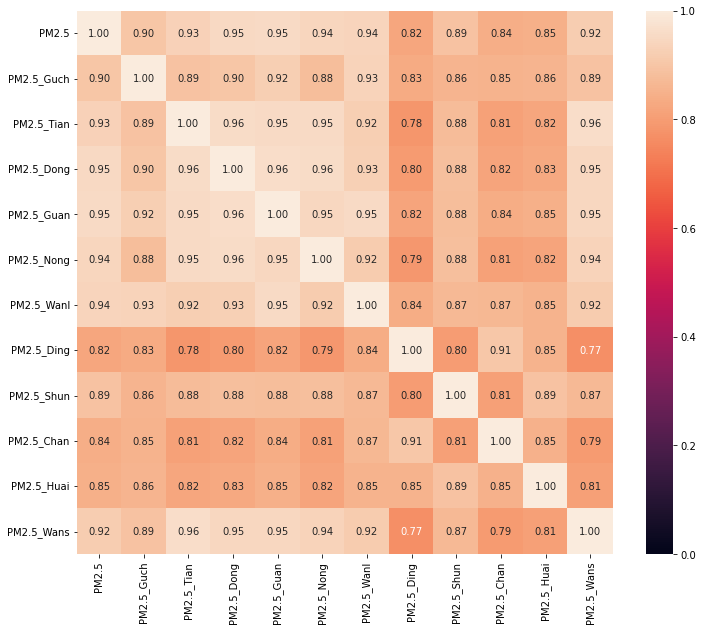

In [16]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df.corr(), annot=True, fmt='.2f', vmin=0., vmax=1.)
plt.show()

In [17]:
final_df = corr_df.copy()
cols = ['PM10', 'CO', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM']
for col in cols:
    cmin = dfs['Aotizhongxin'][col].min()
    cmax = dfs['Aotizhongxin'][col].max()
    final_df[col] = (dfs['Aotizhongxin'][col]-cmin)/(cmax-cmin)
final_df = final_df[final_df.columns.tolist()[1:]+[final_df.columns.tolist()[0]]]
final_df.head()

,PM2.5_Guch,PM2.5_Tian,PM2.5_Dong,PM2.5_Guan,PM2.5_Nong,PM2.5_Wanl,PM2.5_Ding,PM2.5_Shun,PM2.5_Chan,PM2.5_Huai,PM2.5_Wans,PM10,CO,TEMP,PRES,DEWP,RAIN,wd,WSPM,PM2.5
0,0.005208,0.003667,0.008174,0.002950,0.003563,0.006283,0.001139,0.001065,0.001136,0.006579,0.006024,0.002037,0.020202,0.280977,0.661319,0.258621,0.0,0.933333,0.392857,0.001117
1,0.005208,0.003667,0.001362,0.002950,0.007126,0.007330,0.004556,0.010650,0.001136,0.002632,0.008032,0.006110,0.020202,0.273997,0.664884,0.268025,0.0,1.000000,0.419643,0.005587
2,0.003906,0.003667,0.005450,0.001475,0.001188,0.001047,0.002278,0.012780,0.001136,0.002632,0.005020,0.005092,0.020202,0.273997,0.670232,0.268025,0.0,0.933333,0.500000,0.004469
3,0.005208,0.003667,0.000000,0.001475,0.003563,0.009424,0.003417,0.010650,0.001136,0.001316,0.005020,0.004073,0.020202,0.268761,0.688057,0.249216,0.0,0.866667,0.276786,0.003352
4,0.003906,0.002445,0.000000,0.001475,0.003563,0.001047,0.002278,0.010650,0.001136,0.001316,0.005020,0.001018,0.020202,0.258290,0.700535,0.247649,0.0,1.000000,0.178571,0.000000


In [67]:
final_df.to_excel('final.xlsx')

In [18]:
LAG = 1
N = LAG*24
EPOCHS = 200
BATCH_SIZE = 32

# LAG: 1 Day

In [62]:
x_train = final_df.iloc[:28052, :].to_numpy()*10
y_train = final_df.iloc[:28052, -1].to_numpy()*10
x_test = final_df.iloc[28052:, :].to_numpy()*10
y_test = final_df.iloc[28052:, -1].to_numpy()*10
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(28052, 20) (28052,) (7012, 20) (7012,)


In [63]:
x_train = np.array([x_train[i:i+24, :] for i in range(len(x_train)-24)])
y_train = np.array([y_train[i+24] for i in range(len(y_train)-24)])
x_test = np.array([x_test[i:i+24, :] for i in range(len(x_test)-24)])
y_test = np.array([y_test[i+24] for i in range(len(y_test)-24)])
x_train = x_train.reshape((len(x_train), 24, 20))
x_test = x_test.reshape((len(x_test), 24, 20))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(28028, 24, 20) (28028,) (6988, 24, 20) (6988,)


In [22]:
model = Sequential()
model.add(keras.Input(shape=(24*LAG, 20, 1)))
model.add(TimeDistributed(Conv1D(64, 3, activation='relu', padding='causal', input_shape=(20, 1))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Conv1D(64, 3, activation='relu', padding='causal')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Conv1D(32, 3, activation='relu', padding='causal')))
model.add(TimeDistributed(MaxPooling1D(3)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100, dropout=0.2, return_sequences=True))
model.add(LSTM(50, dropout=0.3))
model.add(Dense(1, activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 24, 20, 64)       256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 24, 20, 64)       256       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 24, 20, 64)       12352     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 24, 20, 64)       256       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 24, 20, 32)       6

In [23]:
model.compile(
    loss='MSE',
    optimizer='adam',
    metrics=['mean_absolute_error',
             'RootMeanSquaredError']
)

es = keras.callbacks.EarlyStopping(min_delta=1e-3, patience=50)

history = model.fit(
    x_train, y_train, 
    epochs=EPOCHS, batch_size=BATCH_SIZE, 
    validation_data=(x_test, y_test), 
    callbacks=[es]
)

Epoch 1/200
876/876 [==============================] - 25s 14ms/step - loss: 0.1063 - mean_absolute_error: 0.2007 - root_mean_squared_error: 0.3260 - val_loss: 0.0761 - val_mean_absolute_error: 0.1775 - val_root_mean_squared_error: 0.2759
Epoch 2/200
876/876 [==============================] - 11s 13ms/step - loss: 0.0742 - mean_absolute_error: 0.1671 - root_mean_squared_error: 0.2723 - val_loss: 0.0548 - val_mean_absolute_error: 0.1364 - val_root_mean_squared_error: 0.2342
Epoch 3/200
876/876 [==============================] - 12s 14ms/step - loss: 0.0689 - mean_absolute_error: 0.1591 - root_mean_squared_error: 0.2625 - val_loss: 0.0536 - val_mean_absolute_error: 0.1275 - val_root_mean_squared_error: 0.2315
Epoch 4/200
876/876 [==============================] - 12s 14ms/step - loss: 0.0663 - mean_absolute_error: 0.1543 - root_mean_squared_error: 0.2574 - val_loss: 0.0471 - val_mean_absolute_error: 0.1260 - val_root_mean_squared_error: 0.2170
Epoch 5/200
876/876 [=======================

219/219 [==============================] - 2s 7ms/step


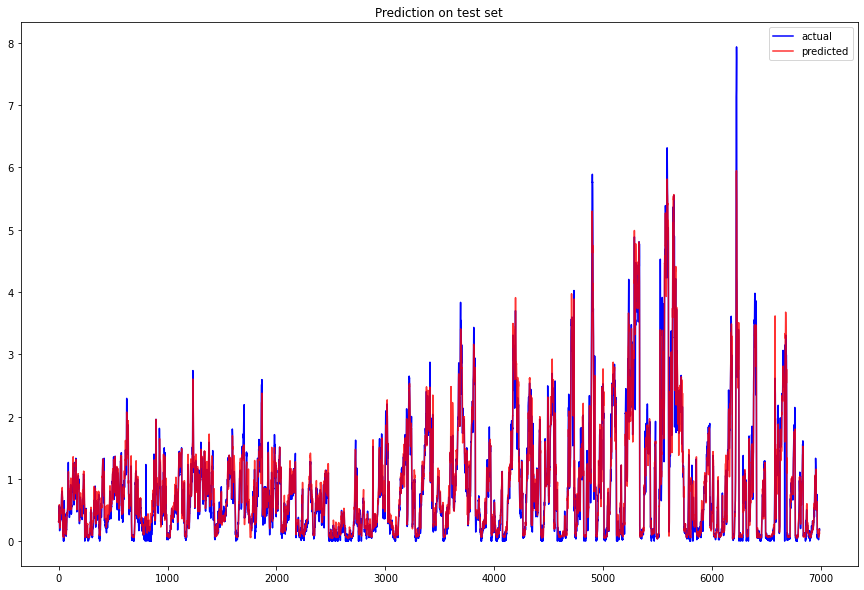

In [32]:
plt.figure(figsize=(15, 10))
y_pred = model.predict(x_test)
plt.plot(y_test, color='blue', label='actual')
plt.plot(y_pred, color='red', label='predicted', alpha=0.8)
plt.legend()
plt.title('Prediction on test set')
plt.show()

876/876 [==============================] - 4s 5ms/step


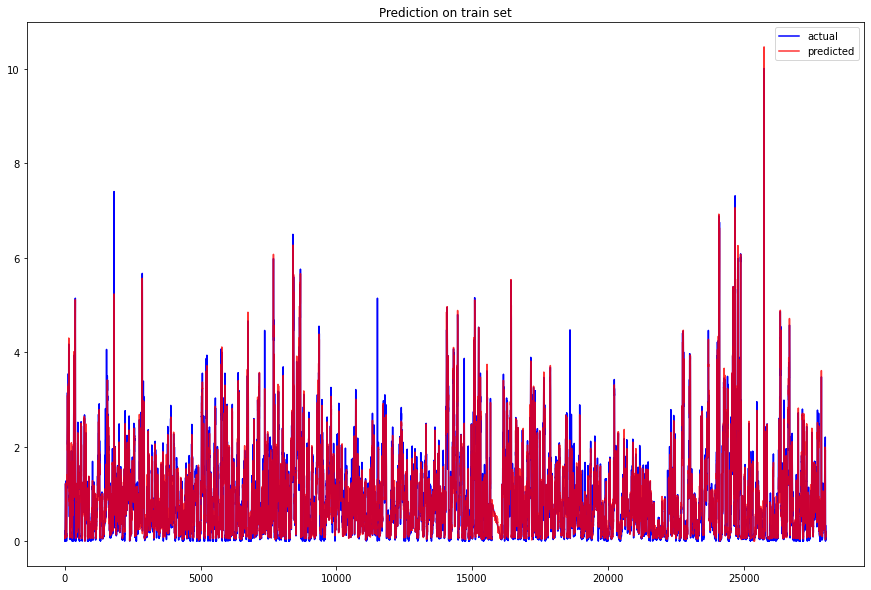

In [33]:
plt.figure(figsize=(15, 10))
y_pred = model.predict(x_train)
plt.plot(y_train, color='blue', label='actual')
plt.plot(y_pred, color='red', label='predicted', alpha=0.8)
plt.legend()
plt.title('Prediction on train set')
plt.show()

In [65]:
metric = RSquare()
y_pred = model.predict(x_train)
metric.update_state(y_train.reshape((-1, 1)), y_pred)
metric.result().numpy()

876/876 [==============================] - 5s 4ms/step


0.97254795

In [66]:
metric = RSquare()
y_pred = model.predict(x_test)
metric.update_state(y_test.reshape((-1, 1)), y_pred)
metric.result().numpy()

219/219 [==============================] - 1s 5ms/step


0.9526104

# LAG: 7 Days

In [58]:
x_train = final_df.iloc[:28052, :].to_numpy()*10
y_train = final_df.iloc[:28052, -1].to_numpy()*10
x_test = final_df.iloc[28052:, :].to_numpy()*10
y_test = final_df.iloc[28052:, -1].to_numpy()*10
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(28052, 20) (28052,) (7012, 20) (7012,)


In [59]:
x_train = np.array([x_train[i:i+7*24, :] for i in range(len(x_train)-7*24)])
y_train = np.array([y_train[i+7*24] for i in range(len(y_train)-7*24)])
x_test = np.array([x_test[i:i+7*24, :] for i in range(len(x_test)-7*24)])
y_test = np.array([y_test[i+7*24] for i in range(len(y_test)-7*24)])
x_train = x_train.reshape((len(x_train), 7*24, 20))
x_test = x_test.reshape((len(x_test), 7*24, 20))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(27884, 168, 20) (27884,) (6844, 168, 20) (6844,)


In [37]:
model_7 = Sequential()
model_7.add(keras.Input(shape=(24*7, 20, 1)))
model_7.add(TimeDistributed(Conv1D(64, 3, activation='relu', padding='causal', input_shape=(20, 1))))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(Conv1D(64, 3, activation='relu', padding='causal')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(Conv1D(32, 3, activation='relu', padding='causal')))
model_7.add(TimeDistributed(MaxPooling1D(3)))
model_7.add(TimeDistributed(Flatten()))
model_7.add(LSTM(100, dropout=0.2, return_sequences=True))
model_7.add(LSTM(50, dropout=0.3))
model_7.add(Dense(1, activation='relu'))
model_7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeDi  (None, 168, 20, 64)      256       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 168, 20, 64)      256       
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 168, 20, 64)      12352     
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 168, 20, 64)      256       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 168, 20, 32)     

In [39]:
model_7.compile(
    loss='MSE',
    optimizer='adam',
    metrics=['mean_absolute_error',
             'RootMeanSquaredError']
)

es = keras.callbacks.EarlyStopping(min_delta=1e-3, patience=50)

history = model_7.fit(
    x_train, y_train, 
    epochs=EPOCHS, batch_size=BATCH_SIZE, 
    validation_data=(x_test, y_test), 
    callbacks=[es]
)

Epoch 1/200
872/872 [==============================] - 47s 48ms/step - loss: 0.1042 - mean_absolute_error: 0.1971 - root_mean_squared_error: 0.3228 - val_loss: 0.1082 - val_mean_absolute_error: 0.2192 - val_root_mean_squared_error: 0.3289
Epoch 2/200
872/872 [==============================] - 40s 46ms/step - loss: 0.0735 - mean_absolute_error: 0.1646 - root_mean_squared_error: 0.2711 - val_loss: 0.0473 - val_mean_absolute_error: 0.1364 - val_root_mean_squared_error: 0.2175
Epoch 3/200
872/872 [==============================] - 40s 46ms/step - loss: 0.0698 - mean_absolute_error: 0.1583 - root_mean_squared_error: 0.2642 - val_loss: 0.0569 - val_mean_absolute_error: 0.1391 - val_root_mean_squared_error: 0.2385
Epoch 4/200
872/872 [==============================] - 40s 46ms/step - loss: 0.0665 - mean_absolute_error: 0.1527 - root_mean_squared_error: 0.2579 - val_loss: 0.0452 - val_mean_absolute_error: 0.1260 - val_root_mean_squared_error: 0.2127
Epoch 5/200
872/872 [=======================

872/872 [==============================] - 12s 13ms/step


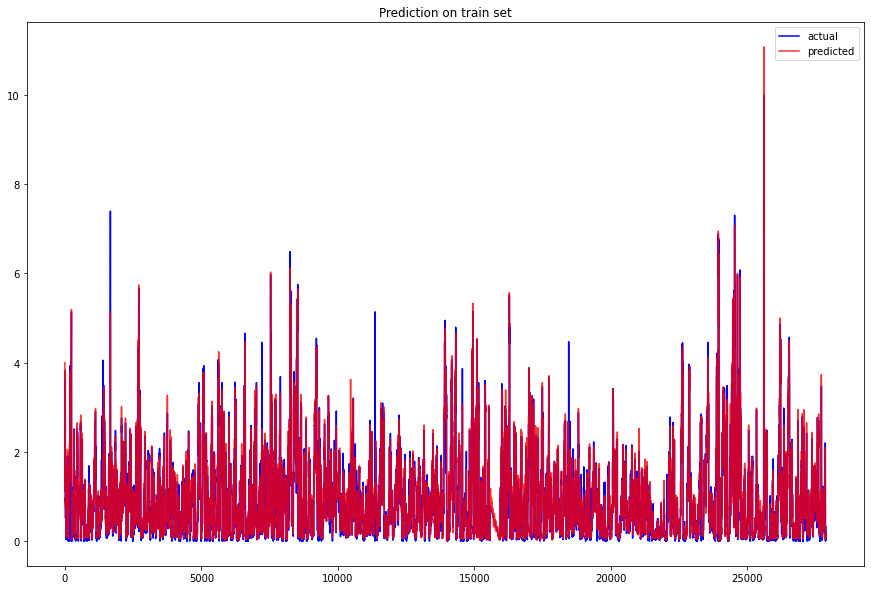

In [42]:
plt.figure(figsize=(15, 10))
y_pred = model_7.predict(x_train)
plt.plot(y_train, color='blue', label='actual')
plt.plot(y_pred, color='red', label='predicted', alpha=0.8)
plt.legend()
plt.title('Prediction on train set')
plt.show()

214/214 [==============================] - 3s 15ms/step


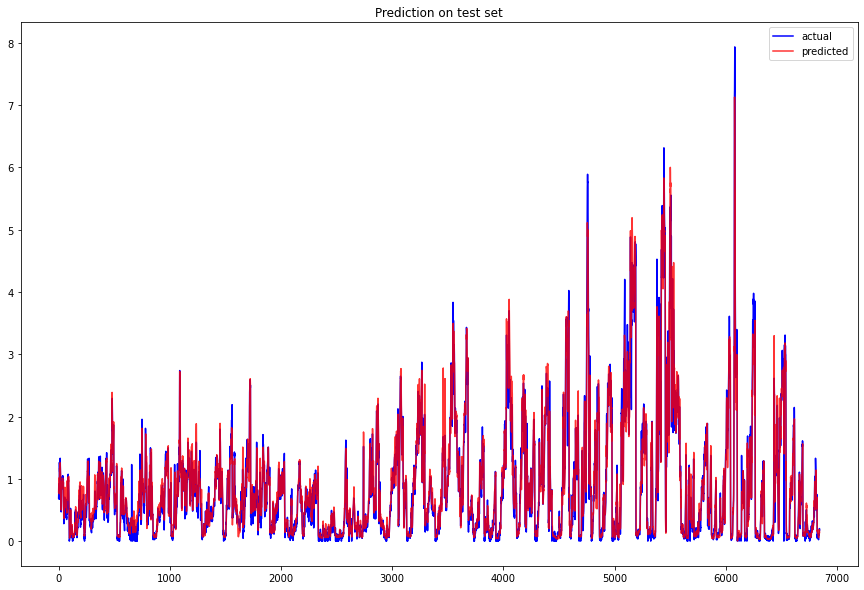

In [44]:
plt.figure(figsize=(15, 10))
y_pred = model_7.predict(x_test)
plt.plot(y_test, color='blue', label='actual')
plt.plot(y_pred, color='red', label='predicted', alpha=0.8)
plt.legend()
plt.title('Prediction on test set')
plt.show()

In [60]:
metric = RSquare()
y_pred = model_7.predict(x_train)
metric.update_state(y_train.reshape((-1, 1)), y_pred)
metric.result().numpy()

872/872 [==============================] - 12s 13ms/step


0.96869344

In [61]:
metric = RSquare()
y_pred = model_7.predict(x_test)
metric.update_state(y_test.reshape((-1, 1)), y_pred)
metric.result().numpy()

214/214 [==============================] - 3s 13ms/step


0.9537007